<a href="https://colab.research.google.com/github/elyzz001/tf_quantum/blob/master/docs/tutorials/noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Noise

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/noise"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/noise.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/noise.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/quantum/docs/tutorials/noise.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Noise is present in modern day quantum computers. Qubits are susceptible to interference from the surrounding environment, imperfect fabrication, TLS and sometimes even [gamma rays](https://arxiv.org/abs/2104.05219). Until large scale error correction is reached, the algorithms of today must be able to remain functional in the presence of noise. This makes testing algorithms under noise an important step for validating quantum algorithms / models will function on the quantum computers of today.

In this tutorial you will explore the basics of noisy circuit simulation in TFQ via the high level `tfq.layers` API.

## Setup

In [3]:
#!pip install tensorflow==2.15.0
!pip install tensorflow-quantum  # ==0.7.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.8/598.8 kB 40.5 MB/s eta 0:00:00


In [29]:
!pip install tensorflow_docs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 3.5 MB/s eta 0:00:00


In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

In [4]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py'>

In [32]:
import random
import cirq
import sympy
import tensorflow_quantum as tfq
import tensorflow as tf
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

## 1. Understanding quantum noise

### 1.1 Basic circuit noise

Noise on a quantum computer impacts the bitstring samples you are able to measure from it. One intuitive way you can start to think about this is that a noisy quantum computer will "insert", "delete" or "replace" gates in random places like the diagram below:

<img src="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/images/noise_1.png?raw=1" width=700>

Building off of this intuition, when dealing with noise, you are no longer using a single pure state $|\psi \rangle$ but instead dealing with an *ensemble* of all possible noisy realizations of your desired circuit: $\rho = \sum_j p_j |\psi_j \rangle \langle \psi_j |$ . Where $p_j$ gives the probability that the system is in $|\psi_j \rangle$ .

Revisiting the above picture, if we knew beforehand that 90% of the time our system executed perfectly, or errored 10% of the time with just this one mode of failure, then our ensemble would be:

$\rho = 0.9 |\psi_\text{desired} \rangle \langle \psi_\text{desired}| + 0.1 |\psi_\text{noisy} \rangle \langle \psi_\text{noisy}| $

If there was more than just one way that our circuit could error, then the ensemble $\rho$ would contain more than just two terms (one for each new noisy realization that could happen). $\rho$ is referred to as the [density matrix](https://en.wikipedia.org/wiki/Density_matrix) describing your noisy system.

### 1.2 Using channels to model circuit noise

Unfortunately in practice it's nearly impossible to know all the ways your circuit might error and their exact probabilities. A simplifying assumption you can make is that after each operation in your circuit there is some kind of [channel](https://quantumai.google/cirq/noise) that roughly captures how that operation might error. You can quickly create a circuit with some noise:

In [8]:
def x_circuit(qubits):
  """Produces an X wall circuit on `qubits`."""
  return cirq.Circuit(cirq.X.on_each(*qubits))

def make_noisy(circuit, p):
  """Add a depolarization channel to all qubits in `circuit` before measurement."""
  return circuit + cirq.Circuit(cirq.depolarize(p).on_each(*circuit.all_qubits()))

my_qubits = cirq.GridQubit.rect(1, 2)
my_circuit = x_circuit(my_qubits)
my_noisy_circuit = make_noisy(my_circuit, 0.5)
my_circuit

(0, 0): ───X───

(0, 1): ───X───

In [9]:
my_noisy_circuit

(0, 0): ───X───D(0.5)───

(0, 1): ───X───D(0.5)───

You can examine the noiseless density matrix $\rho$ with:

In [10]:
rho = cirq.final_density_matrix(my_circuit)
np.round(rho, 3)

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]], dtype=complex64)

And the noisy density matrix $\rho$ with:


In [11]:
rho = cirq.final_density_matrix(my_noisy_circuit)
np.round(rho, 3)

array([[0.111+0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j],
       [0.   +0.j, 0.222+0.j, 0.   +0.j, 0.   +0.j],
       [0.   +0.j, 0.   +0.j, 0.222+0.j, 0.   +0.j],
       [0.   +0.j, 0.   +0.j, 0.   +0.j, 0.444+0.j]], dtype=complex64)

Comparing the two different $ \rho $ 's you can see that the noise has impacted the amplitudes of the state (and consequently sampling probabilities). In the noiseless case you would always expect to sample the $ |11\rangle $ state. But in the noisy state there is now a nonzero probability of sampling $ |00\rangle $ or $ |01\rangle $ or $ |10\rangle $ as well:

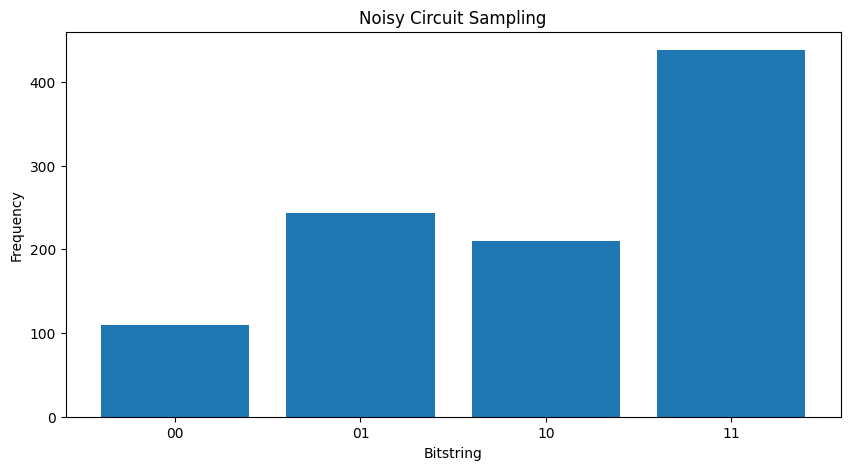

In [12]:
"""Sample from my_noisy_circuit."""
def plot_samples(circuit):
  samples = cirq.sample(circuit + cirq.measure(*circuit.all_qubits(), key='bits'), repetitions=1000)
  freqs, _ = np.histogram(samples.data['bits'], bins=[i+0.01 for i in range(-1,2** len(my_qubits))])
  plt.figure(figsize=(10,5))
  plt.title('Noisy Circuit Sampling')
  plt.xlabel('Bitstring')
  plt.ylabel('Frequency')
  plt.bar([i for i in range(2** len(my_qubits))], freqs, tick_label=['00','01','10','11'])

plot_samples(my_noisy_circuit)

Without any noise you will always get $|11\rangle$:

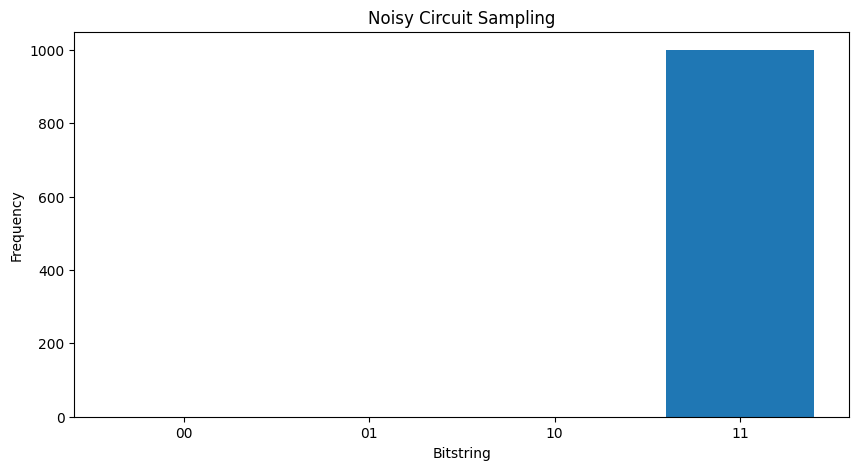

In [13]:
"""Sample from my_circuit."""
plot_samples(my_circuit)

If you increase the noise a little further it will become harder and harder to distinguish the desired behavior (sampling $|11\rangle$ ) from the noise:

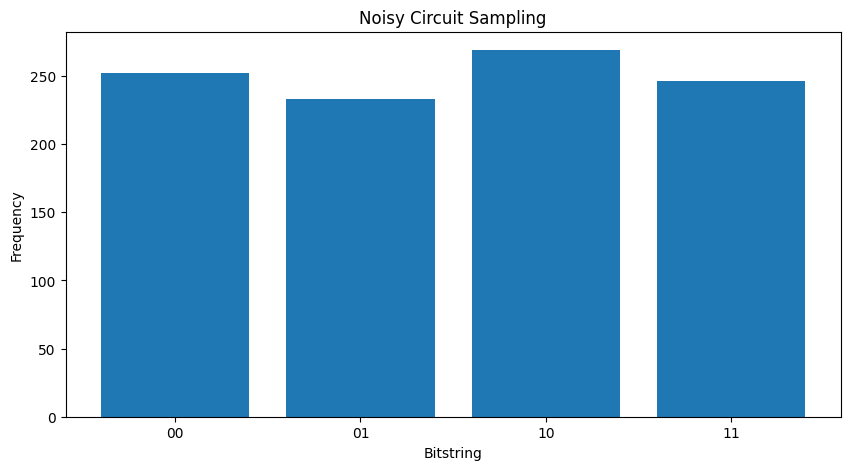

In [14]:
my_really_noisy_circuit = make_noisy(my_circuit, 0.75)
plot_samples(my_really_noisy_circuit)

Note: Try experimenting with different channels in your circuit to generate noise. Common channels supported in both Cirq and TFQ can be found [here](https://github.com/quantumlib/Cirq/blob/master/cirq-core/cirq/ops/common_channels.py)

## 2. Basic noise in TFQ
With this understanding of how noise can impact circuit execution, you can explore how noise works in TFQ. TensorFlow Quantum uses monte-carlo / trajectory based simulation as an alternative to density matrix simulation. This is because the memory complexity of density matrix simulation limits large simulations to being <= 20 qubits with traditional full density matrix simulation methods. Monte-carlo / trajectory trades this cost in memory for additional cost in time. The `backend='noisy'` option available to all `tfq.layers.Sample`, `tfq.layers.SampledExpectation` and `tfq.layers.Expectation` (In the case of `Expectation` this does add a required `repetitions` parameter).

### 2.1 Noisy sampling in TFQ
To recreate the above plots using TFQ and trajectory simulation you can use `tfq.layers.Sample`

In [15]:
"""Draw bitstring samples from `my_noisy_circuit`"""
bitstrings = tfq.layers.Sample(backend='noisy')(my_noisy_circuit, repetitions=1000)

<BarContainer object of 4 artists>

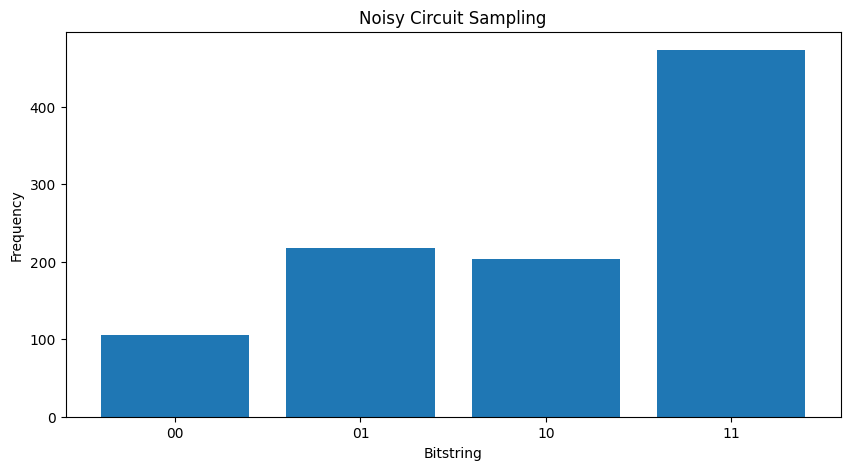

In [16]:
numeric_values = np.einsum('ijk,k->ij', bitstrings.to_tensor().numpy(), [1, 2])[0]
freqs, _ = np.histogram(numeric_values, bins=[i+0.01 for i in range(-1,2** len(my_qubits))])
plt.figure(figsize=(10,5))
plt.title('Noisy Circuit Sampling')
plt.xlabel('Bitstring')
plt.ylabel('Frequency')
plt.bar([i for i in range(2** len(my_qubits))], freqs, tick_label=['00','01','10','11'])

### 2.2 Noisy sample based expectation
To do noisy sample based expectation calculation you can use `tfq.layers.SampleExpectation`:


In [17]:
some_observables = [cirq.X(my_qubits[0]), cirq.Z(my_qubits[0]), 3.0 * cirq.Y(my_qubits[1]) + 1]
some_observables

[cirq.X(cirq.GridQubit(0, 0)),
 cirq.Z(cirq.GridQubit(0, 0)),
 cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.GridQubit(0, 1), cirq.Y)}): (3+0j), frozenset(): (1+0j)}))]

Compute the noiseless expectation estimates via sampling from the circuit:

In [18]:
noiseless_sampled_expectation = tfq.layers.SampledExpectation(backend='noiseless')(
    my_circuit, operators=some_observables, repetitions=10000
)
noiseless_sampled_expectation.numpy()

array([[-0.0066, -1.    ,  0.9964]], dtype=float32)

Compare those with the noisy versions:

In [19]:
noisy_sampled_expectation = tfq.layers.SampledExpectation(backend='noisy')(
    [my_noisy_circuit, my_really_noisy_circuit], operators=some_observables, repetitions=10000
)
noisy_sampled_expectation.numpy()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


array([[-0.004     , -0.34719998,  1.015     ],
       [-0.0122    , -0.01      ,  0.97720003]], dtype=float32)

You can see that the noise has particularly impacted the $\langle \psi | Z | \psi \rangle$ accuracy, with `my_really_noisy_circuit` concentrating very quickly towards 0.

### 2.3 Noisy analytic expectation calculation
Doing noisy analytic expectation calculations is nearly identical to above:



In [20]:
noiseless_analytic_expectation = tfq.layers.Expectation(backend='noiseless')(
    my_circuit, operators=some_observables
)
noiseless_analytic_expectation.numpy()

array([[ 1.9106853e-15, -1.0000000e+00,  1.0000002e+00]], dtype=float32)

In [21]:
noisy_analytic_expectation = tfq.layers.Expectation(backend='noisy')(
    [my_noisy_circuit, my_really_noisy_circuit], operators=some_observables, repetitions=10000
)
noisy_analytic_expectation.numpy()

array([[ 1.9106855e-15, -3.4299999e-01,  1.0000001e+00],
       [ 1.9106855e-15,  1.4000000e-03,  1.0000000e+00]], dtype=float32)

## 3. Hybrid models and quantum data noise
Now that you have implemented some noisy circuit simulations in TFQ, you can experiment with how noise impacts quantum and hybrid quantum classical models, by comparing and contrasting their noisy vs noiseless performance. A good first check to see if a model or algorithm is robust to noise is to test under a circuit wide depolarizing model which looks something like this:

<img src="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/images/noise_2.png?raw=1" width=500>

Where each time slice of the circuit (sometimes referred to as moment) has a depolarizing channel appended after each gate operation in that time slice. The depolarizing channel with apply one of $\{X, Y, Z \}$ with probability $p$ or apply nothing (keep the original operation) with probability $1-p$.

### 3.1 Data
For this example you can use some prepared circuits in the `tfq.datasets` module as training data:

In [22]:
qubits = cirq.GridQubit.rect(1, 8)
circuits, labels, pauli_sums, _ = tfq.datasets.xxz_chain(qubits, 'closed')
circuits[0]

184449737/184449737 [==============================] - 3s 0us/step


┌──────────────────┐   ┌──────────────────────┐   ┌──────────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌──────────────────┐                                        ┌──────────────────┐   ┌──────────────────┐   ┌──────────────────┐                                        ┌──────────────────┐   ┌──────────────────┐   ┌──────────────────┐
(0, 0): ───X───H───@─────────────ZZ───────────────────────YY─────────────────────────XX─────────────ZZ──────────YY──────────XX────────────────────ZZ─────────────────────YY─────────────────────XX───────────ZZ─────────YY───────────XX─────────────────────ZZ─────────────────────YY─────────────────────XX───────────ZZ─────────YY───────────XX─────────────────────ZZ─────────────────────YY─────────────────────XX───────────ZZ──────────YY──────────XX──────────
                   │             │                        │                          │              │           │           │                     │                      │                      │            │          │            │                      │                      │                      │            │          │            │                      │                      │                      │            │           │           │
(0, 1): ───X───────X────ZZ───────┼─────────────YY─────────┼───────────────XX─────────┼──────────────ZZ^-0.941───YY^-0.767───XX^-0.767────ZZ───────┼─────────────YY───────┼─────────────XX───────┼────────────ZZ^-0.98───YY^(-9/11)───XX^(-9/11)────ZZ───────┼─────────────YY───────┼─────────────XX───────┼────────────ZZ^-0.98───YY^(-9/11)───XX^(-9/11)────ZZ───────┼─────────────YY───────┼─────────────XX───────┼────────────ZZ^-0.985───YY^-0.901───XX^-0.901───
                        │        │             │          │               │          │                                                   │        │             │        │             │        │                                                  │        │             │        │             │        │                                                  │        │             │        │             │        │
(0, 2): ───X───H───@────ZZ^-0.977┼─────────────YY^(-10/11)┼───────────────XX^(-10/11)┼──────────────ZZ──────────YY──────────XX───────────ZZ^-0.968┼─────────────YY^-0.898┼─────────────XX^-0.898┼────────────ZZ─────────YY───────────XX────────────ZZ^-0.962┼─────────────YY^-0.869┼─────────────XX^-0.869┼────────────ZZ─────────YY───────────XX────────────ZZ^-0.954┼─────────────YY^-0.904┼─────────────XX^-0.904┼────────────ZZ──────────YY──────────XX──────────
                   │             │                        │                          │              │           │           │                     │                      │                      │            │          │            │                      │                      │                      │            │          │            │                      │                      │                      │            │           │           │
(0, 3): ───X───────X────ZZ───────┼─────────────YY─────────┼───────────────XX─────────┼──────────────ZZ^-0.941───YY^-0.767───XX^-0.767────ZZ───────┼─────────────YY───────┼─────────────XX───────┼────────────ZZ^-0.98───YY^(-9/11)───XX^(-9/11)────ZZ───────┼─────────────YY───────┼─────────────XX───────┼────────────ZZ^-0.98───YY^(-9/11)───XX^(-9/11)────ZZ───────┼─────────────YY───────┼─────────────XX───────┼────────────ZZ^-0.985───YY^-0.901───XX^-0.901───
                        │        │             │          │               │          │                                                   │        │             │        │             │        │                                                  │        │             │        │             │        │                                                  │        │             │        │             │        │
(0, 4): ───X───H───@────ZZ^-0.977┼─────────────YY^(-10/11)┼───────────────XX^(-10/11)┼────────

Writing a small helper function will help to generate the data for the noisy vs noiseless case:

In [23]:
def get_data(qubits, depolarize_p=0.):
  """Return quantum data circuits and labels in `tf.Tensor` form."""
  circuits, labels, pauli_sums, _ = tfq.datasets.xxz_chain(qubits, 'closed')
  if depolarize_p >= 1e-5:
    circuits = [circuit.with_noise(cirq.depolarize(depolarize_p)) for circuit in circuits]
  tmp = list(zip(circuits, labels))
  random.shuffle(tmp)
  circuits_tensor = tfq.convert_to_tensor([x[0] for x in tmp])
  labels_tensor = tf.convert_to_tensor([x[1] for x in tmp])

  return circuits_tensor, labels_tensor

### 3.2 Define a model circuit
Now that you have quantum data in the form of circuits, you will need a circuit to model this data, like with the data you can write a helper function to generate this circuit optionally containing noise:

In [24]:
def modelling_circuit(qubits, depth, depolarize_p=0.):
  """A simple classifier circuit."""
  dim = len(qubits)
  ret = cirq.Circuit(cirq.H.on_each(*qubits))

  for i in range(depth):
    # Entangle layer.
    ret += cirq.Circuit(cirq.CX(q1, q2) for (q1, q2) in zip(qubits[::2], qubits[1::2]))
    ret += cirq.Circuit(cirq.CX(q1, q2) for (q1, q2) in zip(qubits[1::2], qubits[2::2]))
    # Learnable rotation layer.
    # i_params = sympy.symbols(f'layer-{i}-0:{dim}')
    param = sympy.Symbol(f'layer-{i}')
    single_qb = cirq.X
    if i % 2 == 1:
      single_qb = cirq.Y
    ret += cirq.Circuit(single_qb(q) ** param for q in qubits)

  if depolarize_p >= 1e-5:
    ret = ret.with_noise(cirq.depolarize(depolarize_p))

  return ret, [op(q) for q in qubits for op in [cirq.X, cirq.Y, cirq.Z]]

modelling_circuit(qubits, 3)[0]

(0, 0): ───H───@───────X^(layer-0)───@───────Y^(layer-1)───@───────X^(layer-2)───
               │                     │                     │
(0, 1): ───H───X───@───X^(layer-0)───X───@───Y^(layer-1)───X───@───X^(layer-2)───
                   │                     │                     │
(0, 2): ───H───@───X───X^(layer-0)───@───X───Y^(layer-1)───@───X───X^(layer-2)───
               │                     │                     │
(0, 3): ───H───X───@───X^(layer-0)───X───@───Y^(layer-1)───X───@───X^(layer-2)───
                   │                     │                     │
(0, 4): ───H───@───X───X^(layer-0)───@───X───Y^(layer-1)───@───X───X^(layer-2)───
               │                     │                     │
(0, 5): ───H───X───@───X^(layer-0)───X───@───Y^(layer-1)───X───@───X^(layer-2)───
                   │                     │                     │
(0, 6): ───H───@───X───X^(layer-0)───@───X───Y^(layer-1)───@───X───X^(layer-2)───
               │                     │                     │
(0, 7): ───H───X───────X^(layer-0)───X───────Y^(layer-1)───X───────X^(layer-2)───

### 3.3 Model building and training
With your data and model circuit built, the final helper function you will need is one that can assemble both a noisy or a noiseless hybrid quantum `tf.keras.Model`:

In [25]:
def build_keras_model(qubits, depolarize_p=0.):
  """Prepare a noisy hybrid quantum classical Keras model."""
  spin_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

  circuit_and_readout = modelling_circuit(qubits, 4, depolarize_p)
  if depolarize_p >= 1e-5:
    quantum_model = tfq.layers.NoisyPQC(*circuit_and_readout, sample_based=False, repetitions=10)(spin_input)
  else:
    quantum_model = tfq.layers.PQC(*circuit_and_readout)(spin_input)

  intermediate = tf.keras.layers.Dense(4, activation='sigmoid')(quantum_model)
  post_process = tf.keras.layers.Dense(1)(intermediate)

  return tf.keras.Model(inputs=[spin_input], outputs=[post_process])

## 4. Compare performance

### 4.1 Noiseless baseline

With your data generation and model building code, you can now compare and contrast model performance in the noiseless and noisy settings, first you can run a reference noiseless training:

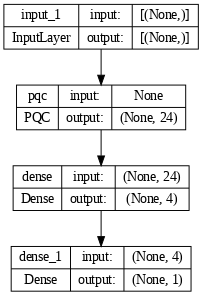

In [26]:
training_histories = dict()
depolarize_p = 0.
n_epochs = 50
phase_classifier = build_keras_model(qubits, depolarize_p)

phase_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=['accuracy'])


# Show the keras plot of the model
tf.keras.utils.plot_model(phase_classifier, show_shapes=True, dpi=70)

In [27]:
noiseless_data, noiseless_labels = get_data(qubits, depolarize_p)
training_histories['noiseless'] = phase_classifier.fit(x=noiseless_data,
                         y=noiseless_labels,
                         batch_size=16,
                         epochs=n_epochs,
                         validation_split=0.15,
                         verbose=1)

Epoch 1/50
4/4 [==============================] - 4s 308ms/step - loss: 0.7060 - accuracy: 0.6094 - val_loss: 0.6227 - val_accuracy: 0.3333
Epoch 2/50
4/4 [==============================] - 1s 137ms/step - loss: 0.6686 - accuracy: 0.5000 - val_loss: 0.6274 - val_accuracy: 0.3333
Epoch 3/50
4/4 [==============================] - 0s 124ms/step - loss: 0.6547 - accuracy: 0.5000 - val_loss: 0.6339 - val_accuracy: 0.3333
Epoch 4/50
4/4 [==============================] - 0s 129ms/step - loss: 0.6403 - accuracy: 0.5000 - val_loss: 0.6297 - val_accuracy: 0.3333
Epoch 5/50
4/4 [==============================] - 0s 128ms/step - loss: 0.6274 - accuracy: 0.5000 - val_loss: 0.6102 - val_accuracy: 0.3333
Epoch 6/50
4/4 [==============================] - 0s 133ms/step - loss: 0.6126 - accuracy: 0.5000 - val_loss: 0.5888 - val_accuracy: 0.3333
Epoch 7/50
4/4 [==============================] - 0s 120ms/step - loss: 0.5984 - accuracy: 0.5000 - val_loss: 0.5595 - val_accuracy: 0.4167
Epoch 8/50
4/4 [====

And explore the results and accuracy:

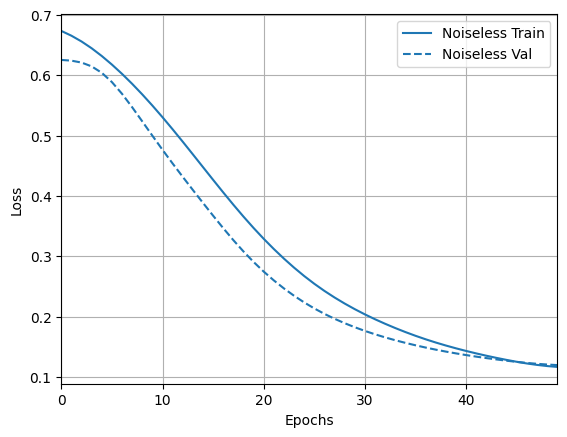

In [33]:
loss_plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
loss_plotter.plot(training_histories)

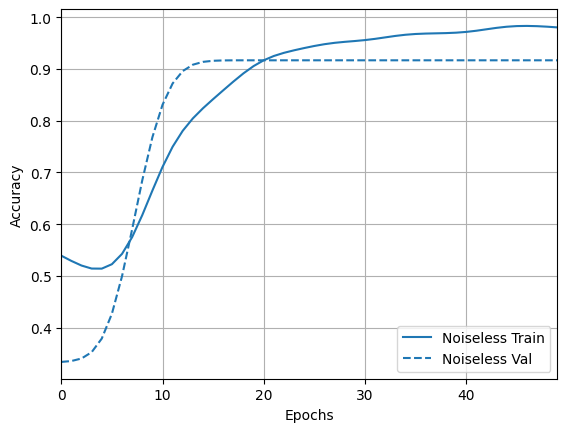

In [34]:
acc_plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
acc_plotter.plot(training_histories)

### 4.2 Noisy comparison
Now you can build a new model with noisy structure and compare to the above, the code is nearly identical:

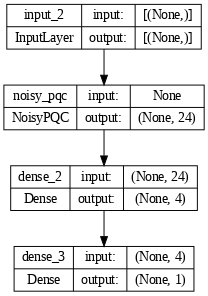

In [35]:
depolarize_p = 0.001
n_epochs = 50
noisy_phase_classifier = build_keras_model(qubits, depolarize_p)

noisy_phase_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=['accuracy'])


# Show the keras plot of the model
tf.keras.utils.plot_model(noisy_phase_classifier, show_shapes=True, dpi=70)

Note: in the model diagram there is now a `tfq.layers.NoisyPQC` instead of a `tfq.layers.PQC` since the depolarization probability is no longer zero. Training will take significantly longer since noisy simulation is far more expensive than noiseless.

In [ ]:
noisy_data, noisy_labels = get_data(qubits, depolarize_p)
training_histories['noisy'] = noisy_phase_classifier.fit(x=noisy_data,
                         y=noisy_labels,
                         batch_size=16,
                         epochs=n_epochs,
                         validation_split=0.15,
                         verbose=1)

Epoch 1/50
4/4 [==============================] - 63s 14s/step - loss: 0.7763 - accuracy: 0.5156 - val_loss: 0.9372 - val_accuracy: 0.2500
Epoch 2/50
4/4 [==============================] - 54s 14s/step - loss: 0.7177 - accuracy: 0.5156 - val_loss: 0.8181 - val_accuracy: 0.2500
Epoch 3/50
4/4 [==============================] - 54s 14s/step - loss: 0.6848 - accuracy: 0.5156 - val_loss: 0.7312 - val_accuracy: 0.2500
Epoch 4/50
4/4 [==============================] - 56s 14s/step - loss: 0.6699 - accuracy: 0.5156 - val_loss: 0.6844 - val_accuracy: 0.2500
Epoch 5/50
4/4 [==============================] - 55s 14s/step - loss: 0.6649 - accuracy: 0.5156 - val_loss: 0.6480 - val_accuracy: 0.2500
Epoch 6/50
4/4 [==============================] - 54s 14s/step - loss: 0.6596 - accuracy: 0.5156 - val_loss: 0.6329 - val_accuracy: 0.2500
Epoch 7/50
4/4 [==============================] - 55s 14s/step - loss: 0.6570 - accuracy: 0.5156 - val_loss: 0.6355 - val_accuracy: 0.2500
Epoch 8/50
4/4 [===========

In [ ]:
loss_plotter.plot(training_histories)

In [ ]:
acc_plotter.plot(training_histories)

Success: The noisy model still managed to train under some mild depolarization noise. Try experimenting with different noise models to see how and when training might fail. Also look out for noisy functionality under `tfq.layers` and `tfq.noise`.